In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

Get the time series for the following cryptocurrencies from cryptowat.ch starting from 2021-11-22, hourly data
- ETH
- SOL
- AVAX
- USDT
- FLOW

In [2]:
def get_data(token, exchange, date='2021-11-22'):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp(date).timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']

In [4]:
df_base = pd.concat(get_data(token, 'coinbase-pro') for token in tokens if token != 'FLOW')
df_base = pd.concat([df_base, get_data('FLOW', 'kraken')])

In [5]:
df = df_base.set_index('ts')

In [6]:
df_base.head()

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volumem

In [7]:
df.groupby('token').sum()['volumeUSD'].to_frame().sort_values('volumeUSD', 
                                                              ascending=False).style.format("{:,.0f}")

,volumeUSD
token,
ETH,"25,045,738,307"
SOL,"8,202,271,129"
AVAX,"4,451,007,538"
USDT,"2,271,357,670"
FLOW,"96,873,996"


Add a column that calculates the close price ratio between ETH and SOL for each house (i.e. close price of ETH / close price of SOL for each period)

In [8]:
df['EthSolSpread'] = (df[df['token']=='ETH']['close'] / df[df['token']=='SOL']['close'])

In [9]:
df.head()

,open,high,low,close,volume,volumeUSD,token,EthSolSpread
ts,,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059


Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm

In [10]:
df.rename(columns={'volume': 'volumeBase', 'volumeUSD': 'volumeTerm'}, inplace=True)

In [11]:
df.head()

,open,high,low,close,volumeBase,volumeTerm,token,EthSolSpread
ts,,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH,18.471694
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH,18.736150
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH,18.577985
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH,18.794937
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH,18.891059


Create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of 200 rows and 5 columns)

In [12]:
df_close = pd.DataFrame(index=df.index, columns = tokens)

In [13]:
for token in tokens:
    df_close[token] = df[df['token']==token]['close']

In [14]:
df_close.head()

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581


In [15]:
df_close.shape

(3350, 5)

Calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-1}))

In [16]:
df_rets = np.log(df_close / df_close.shift(1)).fillna(0)

In [17]:
df_rets.head()

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,0.000000,0.000000,0.000000,0.0000,0.000000
2021-11-22 01:00:00,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,-0.006008,-0.011109,0.021583,-0.0002,-0.005214


[Stretch] calculate the correlation of the tokens using the table above

In [18]:
df_corr = df_rets.corr()
df_corr

,ETH,SOL,AVAX,USDT,FLOW
ETH,1.000000,0.767533,0.688347,-0.050468,0.556962
SOL,0.767533,1.000000,0.686333,0.152995,0.689637
AVAX,0.688347,0.686333,1.000000,0.049197,0.476825
USDT,-0.050468,0.152995,0.049197,1.000000,0.006203
FLOW,0.556962,0.689637,0.476825,0.006203,1.000000


[Stretch] visualize the correlation in a matplpotlib plot

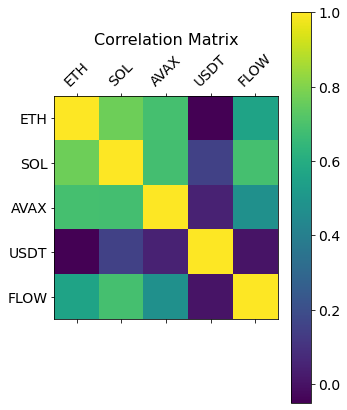

In [19]:
f = plt.figure(figsize=(5, 7))
plt.matshow(df_corr, fignum=f.number)
plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, 
           fontsize=14, rotation=45)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, 
           fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);